In [ ]:
!pip install roboflow
!pip install pillow_heif==0.15.0 # Install a compatible version
from roboflow import Roboflow
rf = Roboflow(api_key="TS1niacLXvvWTierCKCT")
project = rf.workspace("insectai").project("new_images-kmnhv")
version = project.version(1)
dataset = version.download("yolov8")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 74.3 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 29.9 MB/s eta 0:00:00
  Attempting uninstall: pillow_heif
    Found existing installation: pillow_heif 0.22.0
    Uninstalling pillow_heif-0.22.0:
      Successfully uninstalled pillow_heif-0.22.0
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to New_images-1 in yolov8:: 100%|██████████| 66/66 [00:00<00:00, 856.09it/s]


In [ ]:
import cv2
import numpy as np
import os
from glob import glob
from tqdm import tqdm
from collections import Counter
import random

label_dir = os.path.join(dataset.location, "train", "labels")
image_dir = os.path.join(dataset.location, "train", "images")
cropped_output_dir = "cropped_dataset"
os.makedirs(cropped_output_dir, exist_ok=True)

def yolo_to_xyxy(bbox, img_w, img_h):
    x_c, y_c, w, h = bbox
    x1 = int((x_c - w / 2) * img_w)
    y1 = int((y_c - h / 2) * img_h)
    x2 = int((x_c + w / 2) * img_w)
    y2 = int((y_c + h / 2) * img_h)
    return x1, y1, x2, y2

def apply_augmentations(crop):
    angle = random.choice([0, 90, 180, 270])
    angle=angle + (np.random.random_integers(0,15))
    if angle:
        crop = np.rot90(crop, k=angle // 90)

    crop = cv2.GaussianBlur(crop, (5, 5), 0)
    noise = np.random.normal(0, 0.1, crop.shape).astype(np.uint8)
    crop = cv2.add(crop, noise)

    return crop

rare_classes = [0, 2,4]  # Modify as needed
augment_factor = 4

class_counter = Counter()

for label_file in tqdm(glob(f"{label_dir}/*.txt")):
    image_file = label_file.replace('/labels/', '/images/').replace('.txt', '.jpg')
    img = cv2.imread(image_file)
    h, w = img.shape[:2]

    with open(label_file, "r") as f:
        lines = f.readlines()

        for idx, line in enumerate(lines):
            parts = line.strip().split()
            class_id = int(parts[0])
            bbox = list(map(float, parts[1:]))
            x1, y1, x2, y2 = yolo_to_xyxy(bbox, w, h)

            crop = img[y1:y2, x1:x2]
            if crop.size == 0:
                continue

            class_folder = os.path.join(cropped_output_dir, str(class_id))
            os.makedirs(class_folder, exist_ok=True)

            filename = os.path.basename(image_file).replace('.jpg', f'_{idx}.jpg')
            cv2.imwrite(os.path.join(class_folder, filename), crop)
            class_counter[class_id] += 1

            if class_id in rare_classes:
                for aug_idx in range(augment_factor):
                    aug_crop = apply_augmentations(crop)
                    aug_filename = os.path.basename(image_file).replace('.jpg', f'_{idx}_aug{aug_idx}.jpg')
                    cv2.imwrite(os.path.join(class_folder, aug_filename), aug_crop)
                    class_counter[class_id] += 1

print("Class distribution after cropping and augmentation:", class_counter)

NameError: name 'dataset' is not defined

In [ ]:
!rm -rf balanced_dataset

In [ ]:
!rm -rf resnet_split

In [ ]:
import cv2
import numpy as np
import os
from glob import glob
from tqdm import tqdm
from collections import Counter
import random
import shutil
from sklearn.model_selection import train_test_split

# === CONFIGURATION ===
dataset_root = dataset.location
label_dirs = [os.path.join(dataset_root, split, "labels") for split in ["train", "valid"]]
image_dirs = [os.path.join(dataset_root, split, "images") for split in ["train", "valid"]]
output_dir = "balanced_dataset"
os.makedirs(output_dir, exist_ok=True)

# Custom augmentation targets per class
target_counts = {
    0: 100,   # Caddisfly
    2: 100,   # Mayfly
    4: 100,   # Stonefly
}

test_ratio = 0.15
val_ratio = 0.15

# === UTILITIES ===
def yolo_to_xyxy(bbox, img_w, img_h):
    x_c, y_c, w, h = bbox
    x1 = int((x_c - w / 2) * img_w)
    y1 = int((y_c - h / 2) * img_h)
    x2 = int((x_c + w / 2) * img_w)
    y2 = int((y_c + h / 2) * img_h)
    return x1, y1, x2, y2

def apply_augmentations(crop):
    angle = random.choice([0, 90, 180, 270]) + random.randint(0, 15)
    crop = np.rot90(crop, k=angle // 90)
    crop = cv2.GaussianBlur(crop, (5, 5), 0)
    noise = np.random.normal(0, 10, crop.shape).astype(np.uint8)
    crop = cv2.add(crop, noise)
    return crop

# === CROP AND AUGMENT ===
class_counter = Counter()
pre_aug_counter = Counter()
image_paths_by_class = {i: [] for i in range(6)}

for label_dir, image_dir in zip(label_dirs, image_dirs):
    for label_file in tqdm(glob(f"{label_dir}/*.txt")):
        image_file = label_file.replace(label_dir, image_dir).replace('.txt', '.jpg')
        img = cv2.imread(image_file)
        if img is None:
            continue
        h, w = img.shape[:2]

        with open(label_file, "r") as f:
            lines = f.readlines()

        for idx, line in enumerate(lines):
            parts = line.strip().split()
            class_id = int(parts[0])
            bbox = list(map(float, parts[1:]))
            x1, y1, x2, y2 = yolo_to_xyxy(bbox, w, h)
            crop = img[y1:y2, x1:x2]
            if crop.size == 0:
                continue

            class_folder = os.path.join(output_dir, str(class_id))
            os.makedirs(class_folder, exist_ok=True)

            filename = os.path.basename(image_file).replace('.jpg', f'_{idx}.jpg')
            save_path = os.path.join(class_folder, filename)
            cv2.imwrite(save_path, crop)
            image_paths_by_class[class_id].append(save_path)
            class_counter[class_id] += 1
            pre_aug_counter[class_id] += 1

            # Augment only if class is in target_counts and under target
            if class_id in target_counts:
                while class_counter[class_id] < target_counts[class_id]:
                    aug_crop = apply_augmentations(crop)
                    aug_filename = filename.replace('.jpg', f'_aug{class_counter[class_id]}.jpg')
                    aug_path = os.path.join(class_folder, aug_filename)
                    cv2.imwrite(aug_path, aug_crop)
                    image_paths_by_class[class_id].append(aug_path)
                    class_counter[class_id] += 1

# === PRINT COUNTS ===
print("\n📊 Pre-augmentation class distribution:")
for class_id in sorted(pre_aug_counter):
    print(f"Class {class_id}: {pre_aug_counter[class_id]} original crops")

print("\n✅ Final class distribution after augmentation:")
for class_id in sorted(class_counter):
    print(f"Class {class_id}: {class_counter[class_id]} total samples")

# === SPLIT INTO TRAIN/VAL/TEST ===
final_split_dir = "resnet_split"
for split in ["train", "val", "test"]:
    for class_id in range(6):
        os.makedirs(os.path.join(final_split_dir, split, str(class_id)), exist_ok=True)

for class_id, paths in image_paths_by_class.items():
    train_val, test = train_test_split(paths, test_size=test_ratio, random_state=42)
    train, val = train_test_split(train_val, test_size=val_ratio / (1 - test_ratio), random_state=42)

    for split_name, split_paths in zip(["train", "val", "test"], [train, val, test]):
        for path in split_paths:
            dest = os.path.join(final_split_dir, split_name, str(class_id), os.path.basename(path))
            shutil.copy(path, dest)

print("\n📁 Dataset split into train/val/test and ready for ResNet training.")

100%|██████████| 4/4 [00:00<00:00, 20.57it/s]



📊 Pre-augmentation class distribution:
Class 0: 22 original crops
Class 1: 4216 original crops
Class 2: 11 original crops
Class 3: 437 original crops
Class 4: 19 original crops
Class 5: 174 original crops

✅ Final class distribution after augmentation:
Class 0: 421 total samples
Class 1: 4216 total samples
Class 2: 410 total samples
Class 3: 437 total samples
Class 4: 418 total samples
Class 5: 573 total samples

📁 Dataset split into train/val/test and ready for ResNet training.


In [ ]:
import tensorflow as tf

# === CONFIGURATION ===
data_dir = 'resnet_split'
image_size = (224, 224)
batch_size = 32
seed = 42

# === LOAD DATASETS ===
train_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=os.path.join(data_dir, 'train'),
    labels='inferred',
    label_mode='int',
    image_size=image_size,
    batch_size=batch_size,
    shuffle=True,
    seed=seed
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=os.path.join(data_dir, 'val'),
    labels='inferred',
    label_mode='int',
    image_size=image_size,
    batch_size=batch_size,
    shuffle=True,
    seed=seed
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=os.path.join(data_dir, 'test'),
    labels='inferred',
    label_mode='int',
    image_size=image_size,
    batch_size=batch_size,
    shuffle=False
)

# === NORMALIZATION ===
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
validation_dataset = validation_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

# === PREFETCHING ===
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


Found 4527 files belonging to 6 classes.
Found 974 files belonging to 6 classes.
Found 974 files belonging to 6 classes.


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping


checkpoint_cb = ModelCheckpoint(
    filepath='best_model.h5',         # Filepath to save the model
    monitor='val_loss',               # Metric to monitor
    save_best_only=True,              # Only save the best model
    save_weights_only=False,          # Set to True if you want to save weights only
    mode='min',                       # Mode for optimization ('min' for loss)
    verbose=1                         # Prints a message when saving
)


callbacks = [
    checkpoint_cb,
    EarlyStopping(
        patience=5,
        monitor='val_loss',
        min_delta=0,
        mode='min',
        restore_best_weights=True
    )
]

def build_resnet_model(num_classes=6):
    base_model = tf.keras.applications.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3)
    )
    base_model.trainable = True  #Unfreeze base

    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.2),  # Changed from 0.5 to 0.2
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy']
                  )
    return model

In [ ]:
model = build_resnet_model(num_classes=6)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,113,798 (91.99 MB)

 Trainable params: 24,060,678 (91.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Final class counts
class_counts = [421, 4216, 410, 437, 418, 573]
classes = np.arange(len(class_counts))
total = sum(class_counts)

# Compute weights inversely proportional to class frequency
class_weights = {i: total / (len(class_counts) * count) for i, count in enumerate(class_counts)}

print("Class weights:", class_weights)

Class weights: {0: 2.563341250989707, 1: 0.25596932321315624, 2: 2.6321138211382116, 3: 2.469488939740656, 4: 2.581738437001595, 5: 1.8833624200116346}


In [ ]:
model = build_resnet_model(num_classes=6)

history_original_1 = model.fit(train_dataset, validation_data=validation_dataset, epochs=30, callbacks=callbacks class_weight = )

test_loss, test_acc = model.evaluate(test_dataset)
print(f"✅ Test accuracy: {test_acc:.4f}")

Epoch 1/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.7767 - loss: 0.8761
Epoch 1: val_loss improved from inf to 1.37490, saving model to best_model.h5


142/142 ━━━━━━━━━━━━━━━━━━━━ 147s 577ms/step - accuracy: 0.7771 - loss: 0.8742 - val_accuracy: 0.6499 - val_loss: 1.3749
Epoch 2/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.8825 - loss: 0.4547
Epoch 2: val_loss did not improve from 1.37490
142/142 ━━━━━━━━━━━━━━━━━━━━ 45s 315ms/step - accuracy: 0.8825 - loss: 0.4545 - val_accuracy: 0.6499 - val_loss: 1.3911
Epoch 3/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.8855 - loss: 0.4051
Epoch 3: val_loss improved from 1.37490 to 1.36272, saving model to best_model.h5


142/142 ━━━━━━━━━━━━━━━━━━━━ 48s 335ms/step - accuracy: 0.8856 - loss: 0.4050 - val_accuracy: 0.6499 - val_loss: 1.3627
Epoch 4/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.8752 - loss: 0.4300
Epoch 4: val_loss did not improve from 1.36272
142/142 ━━━━━━━━━━━━━━━━━━━━ 79s 313ms/step - accuracy: 0.8753 - loss: 0.4297 - val_accuracy: 0.6499 - val_loss: 1.4819
Epoch 5/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.8885 - loss: 0.3808
Epoch 5: val_loss improved from 1.36272 to 1.26225, saving model to best_model.h5


142/142 ━━━━━━━━━━━━━━━━━━━━ 84s 325ms/step - accuracy: 0.8886 - loss: 0.3806 - val_accuracy: 0.6499 - val_loss: 1.2622
Epoch 6/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.8877 - loss: 0.3788
Epoch 6: val_loss did not improve from 1.26225
142/142 ━━━━━━━━━━━━━━━━━━━━ 80s 314ms/step - accuracy: 0.8877 - loss: 0.3787 - val_accuracy: 0.6478 - val_loss: 7.7549
Epoch 7/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.8928 - loss: 0.3531
Epoch 7: val_loss improved from 1.26225 to 0.77480, saving model to best_model.h5


142/142 ━━━━━━━━━━━━━━━━━━━━ 84s 332ms/step - accuracy: 0.8929 - loss: 0.3530 - val_accuracy: 0.7926 - val_loss: 0.7748
Epoch 8/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.8976 - loss: 0.3288
Epoch 8: val_loss improved from 0.77480 to 0.41016, saving model to best_model.h5


142/142 ━━━━━━━━━━━━━━━━━━━━ 48s 335ms/step - accuracy: 0.8977 - loss: 0.3287 - val_accuracy: 0.8645 - val_loss: 0.4102
Epoch 9/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.8930 - loss: 0.3614
Epoch 9: val_loss did not improve from 0.41016
142/142 ━━━━━━━━━━━━━━━━━━━━ 44s 309ms/step - accuracy: 0.8930 - loss: 0.3614 - val_accuracy: 0.7074 - val_loss: 5.7016
Epoch 10/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.8966 - loss: 0.3441
Epoch 10: val_loss improved from 0.41016 to 0.35732, saving model to best_model.h5


142/142 ━━━━━━━━━━━━━━━━━━━━ 48s 339ms/step - accuracy: 0.8967 - loss: 0.3439 - val_accuracy: 0.9035 - val_loss: 0.3573
Epoch 11/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.9012 - loss: 0.3266
Epoch 11: val_loss did not improve from 0.35732
142/142 ━━━━━━━━━━━━━━━━━━━━ 44s 309ms/step - accuracy: 0.9012 - loss: 0.3265 - val_accuracy: 0.7464 - val_loss: 0.8130
Epoch 12/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.8999 - loss: 0.3281
Epoch 12: val_loss did not improve from 0.35732
142/142 ━━━━━━━━━━━━━━━━━━━━ 83s 313ms/step - accuracy: 0.8999 - loss: 0.3280 - val_accuracy: 0.7690 - val_loss: 1.5190
Epoch 13/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.9017 - loss: 0.3190
Epoch 13: val_loss did not improve from 0.35732
142/142 ━━━━━━━━━━━━━━━━━━━━ 43s 306ms/step - accuracy: 0.9017 - loss: 0.3189 - val_accuracy: 0.9014 - val_loss: 0.3667
Epoch 14/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.8987 - loss: 0.3223
Epoch 14: val_loss d

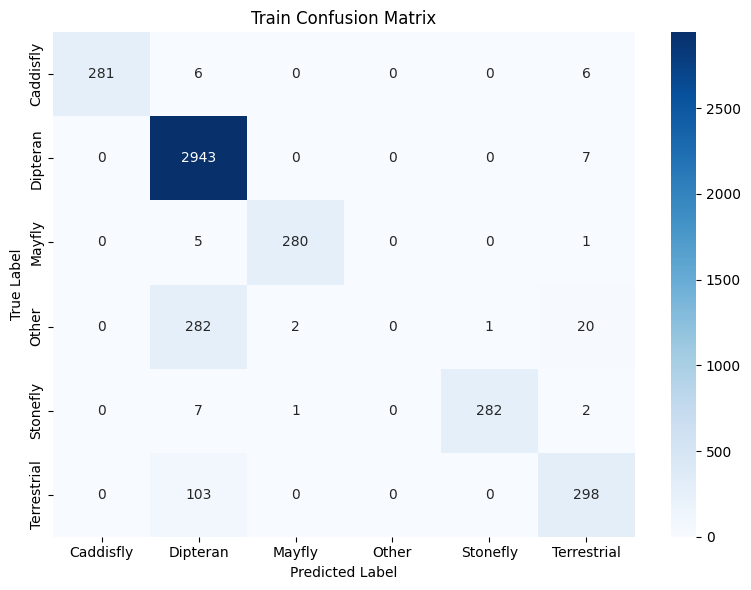

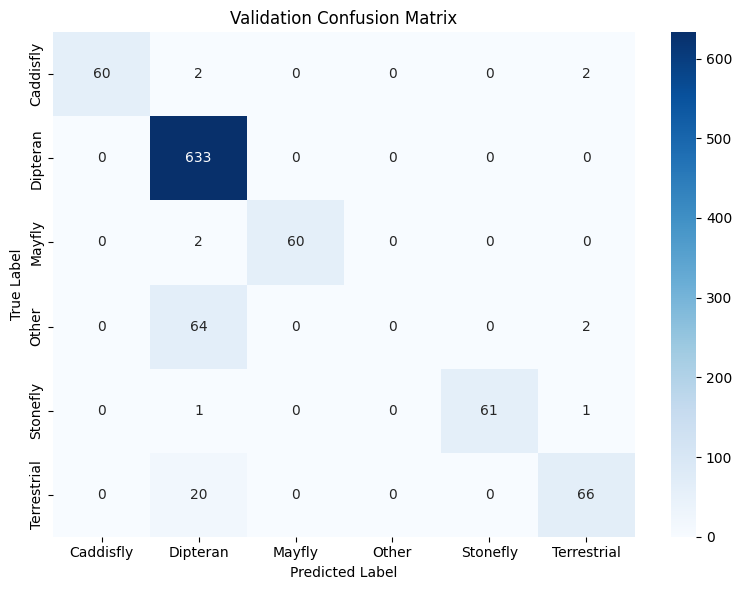

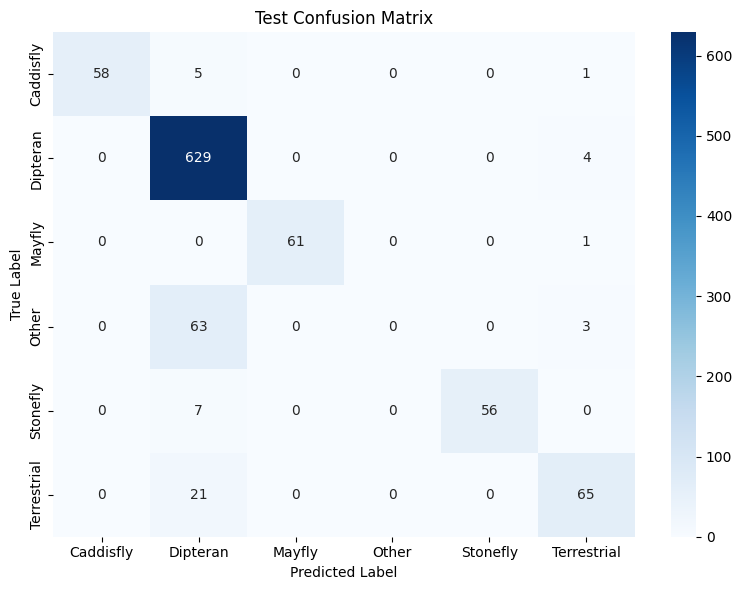

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
class_names = ['Caddisfly', 'Dipteran', 'Mayfly', 'Other', 'Stonefly', 'Terrestrial']

def plot_confusion_matrix(dataset, dataset_name="Dataset"):
    y_true = []
    y_pred = []

    for images, labels in dataset:
        predictions = model.predict(images, verbose=0)
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(predictions, axis=1))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f"{dataset_name} Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()


# Plot for validation and test datasets
plot_confusion_matrix(train_dataset, "Train")
plot_confusion_matrix(validation_dataset, "Validation")
plot_confusion_matrix(test_dataset, "Test")

In [ ]:
def plot_training_curves(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

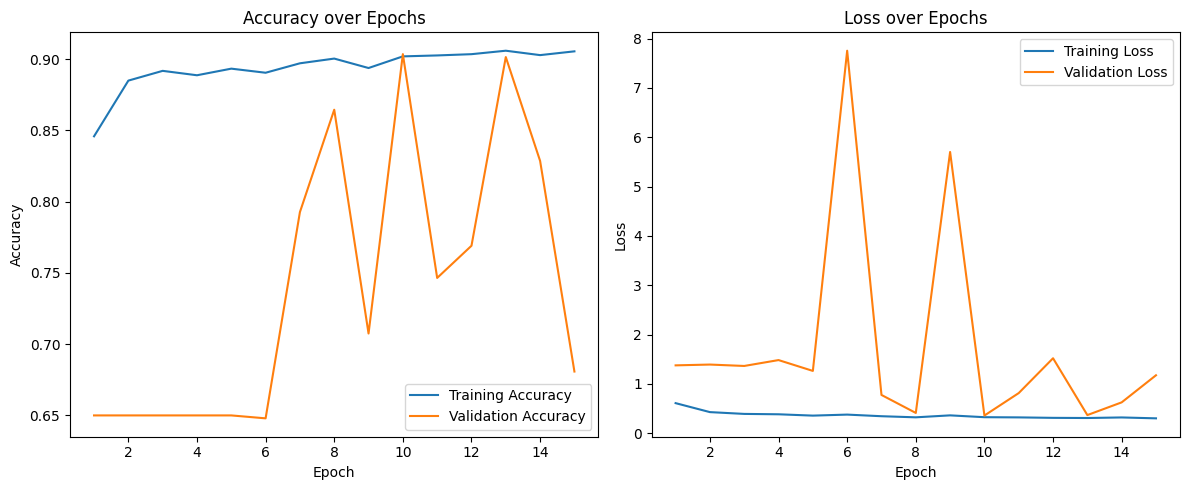

In [ ]:
plot_training_curves(history_original_1)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
class_names = ['Caddisfly', 'Dipteran', 'Mayfly', 'Other', 'Stonefly', 'Terrestrial']

def plot_confusion_matrix(dataset, dataset_name="Dataset", normalize=False):
    y_true = []
    y_pred = []

    for images, labels in dataset:
        predictions = model.predict(images, verbose=0)
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(predictions, axis=1))

    norm_option = 'true' if normalize else None
    cm = confusion_matrix(y_true, y_pred, normalize=norm_option)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=".2f" if normalize else "d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    title = f"{dataset_name} Confusion Matrix"
    if normalize:
        title += " (Normalized)"
    plt.title(title)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()

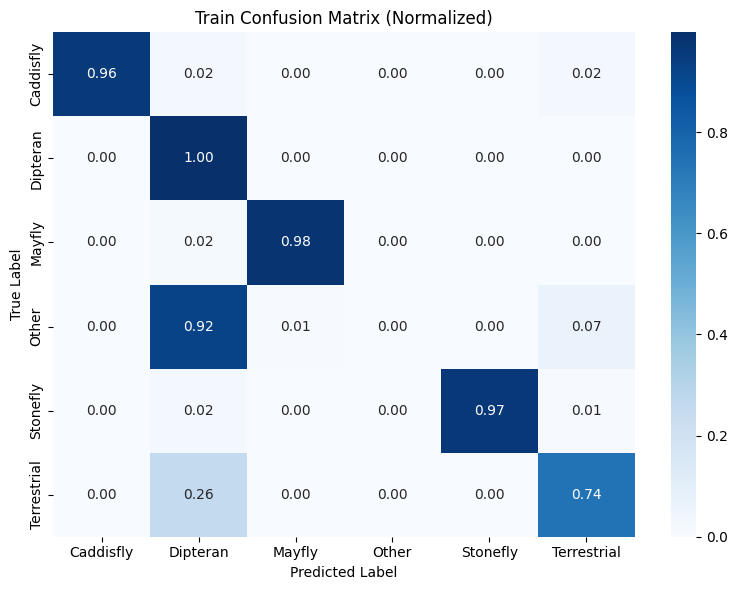

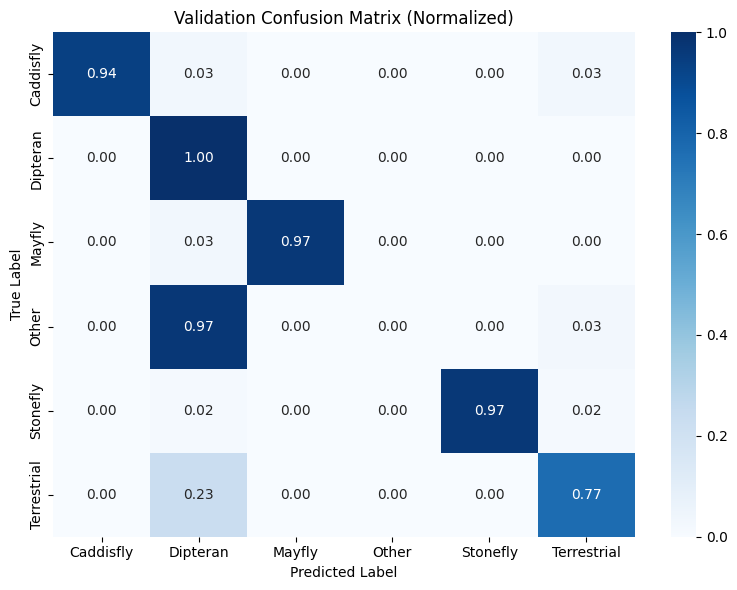

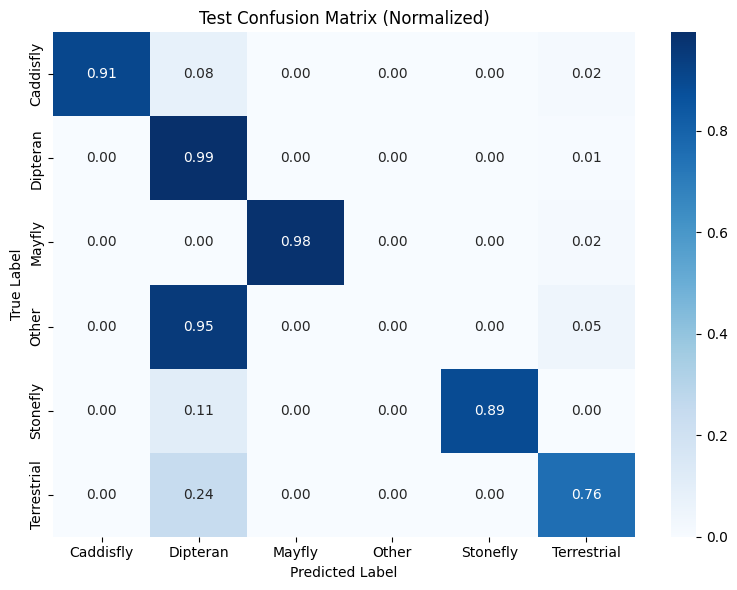

In [ ]:
plot_confusion_matrix(train_dataset, "Train", normalize=True)
plot_confusion_matrix(validation_dataset, "Validation", normalize=True)
plot_confusion_matrix(test_dataset, "Test", normalize=True)


In [ ]:
import os
import cv2
from glob import glob
from tqdm import tqdm

# === CONFIGURATION ===
image_dir = "/content/New_images-1/test/images"
label_dir = "/content/New_images-1/test/labels"
output_dir = "test_noaug"
image_size = (224, 224)

os.makedirs(output_dir, exist_ok=True)

# === HELPER: YOLO to pixel coordinates ===
def yolo_to_xyxy(bbox, img_w, img_h):
    x_c, y_c, w, h = bbox
    x1 = int((x_c - w / 2) * img_w)
    y1 = int((y_c - h / 2) * img_h)
    x2 = int((x_c + w / 2) * img_w)
    y2 = int((y_c + h / 2) * img_h)
    return x1, y1, x2, y2

# === PROCESS EACH IMAGE ===
for label_path in tqdm(glob(os.path.join(label_dir, "*.txt"))):
    image_path = label_path.replace(label_dir, image_dir).replace(".txt", ".jpg")
    img = cv2.imread(image_path)
    if img is None:
        continue
    h, w = img.shape[:2]

    with open(label_path, "r") as f:
        lines = f.readlines()

    for idx, line in enumerate(lines):
        parts = line.strip().split()
        if len(parts) < 5:
            continue
        class_id = int(parts[0])
        bbox = list(map(float, parts[1:]))
        x1, y1, x2, y2 = yolo_to_xyxy(bbox, w, h)
        crop = img[y1:y2, x1:x2]
        if crop.size == 0 or crop.shape[0] < 10 or crop.shape[1] < 10:
            continue

        # Resize crop
        crop_resized = cv2.resize(crop, image_size)

        # Save to class folder
        class_folder = os.path.join(output_dir, str(class_id))
        os.makedirs(class_folder, exist_ok=True)
        filename = os.path.basename(image_path).replace('.jpg', f'_{idx}.jpg')
        save_path = os.path.join(class_folder, filename)
        cv2.imwrite(save_path, crop_resized)

print("\n✅ Test dataset created at:", output_dir)

100%|██████████| 3/3 [00:00<00:00,  8.27it/s]


✅ Test dataset created at: test_noaug


In [ ]:
import os
from collections import Counter

test_dir = "test_noaug"
class_counts = Counter()

for class_name in os.listdir(test_dir):
    class_path = os.path.join(test_dir, class_name)
    if os.path.isdir(class_path):
        num_images = len([f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))])
        class_counts[class_name] = num_images

# Print results
print("\n📊 Test Set Image Counts:")
for class_id in sorted(class_counts, key=lambda x: int(x)):
    print(f"Class {class_id}: {class_counts[class_id]} images")


📊 Test Set Image Counts:
Class 0: 3 images
Class 1: 461 images
Class 3: 63 images
Class 4: 2 images
Class 5: 34 images


In [ ]:
import tensorflow as tf

# === CONFIGURATION ===
test_dir = "test_noaug"
image_size = (224, 224)
batch_size = 32

# === LOAD TEST DATASET ===
test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='int',
    image_size=image_size,
    batch_size=batch_size,
    shuffle=False
)

# === NORMALIZATION & PREFETCHING ===
normalization_layer = tf.keras.layers.Rescaling(1./255)
AUTOTUNE = tf.data.AUTOTUNE

test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# === EVALUATE MODEL ===
loss, accuracy = model.evaluate(test_dataset, verbose=1)
print(f"\n✅ Test Accuracy: {accuracy:.4f}")

from collections import Counter

print("Ground truth class distribution:", Counter(y_true))
print("Predicted class distribution:", Counter(y_pred))

Found 563 files belonging to 5 classes.
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.9420 - loss: 0.5802

✅ Test Accuracy: 0.8153
Ground truth class distribution: Counter({1: 461, 3: 63, 5: 34, 0: 3, 4: 2})
Predicted class distribution: Counter({np.int64(3): 413, np.int64(1): 150})


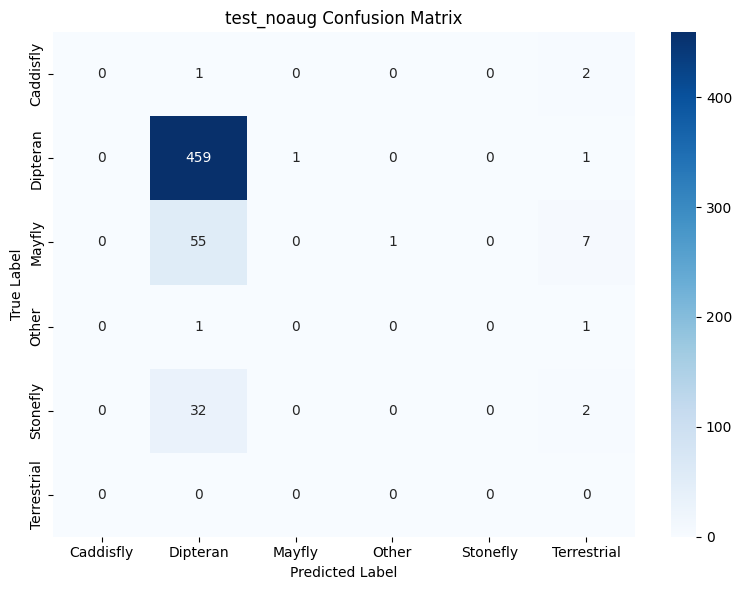

In [ ]:
plot_confusion_matrix(test_dataset, "test_noaug", normalize=False)